# Projet 2 : Analysez des données de systèmes éducatifs

The World Bank EdStats All Indicator Query holds over 4,000 internationally comparable indicators that describe education access, progression, completion, literacy, teachers, population, and expenditures. The indicators cover the education cycle from pre-primary to vocational and tertiary education.The query also holds learning outcome data from international and regional learning assessments (e.g. PISA, TIMSS, PIRLS), equity data from household surveys, and projection/attainment data to 2050.

L'entreprise Academy propose des contenus de formation en ligne pour un public de niveau lycée et université.
L'objectif de la mission est de réaliser une première analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

#### Problématiques : 

- Quels sont les pays avec un fort potentiel de clients pour nos services ?
- Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
- Dans quels pays l'entreprise doit-elle opérer en priorité ?


#### Démarche :

- Description et analyse des données
- Séléction d'indicateurs
- Modèle de scoring
    
Les données utilisés sont disponible à l'adresse suivante : https://datacatalog.worldbank.org/dataset/education-statistics



### Chargement des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

### Lecture des données

In [2]:
path_data = "C:/max/Projet_2/data/"
file_name = os.path.join(path_data, "EdStatsData" + ".csv")

df_data = pd.read_csv(os.path.join(path_data, "EdStatsData" + ".csv"), low_memory=False)
df_country = pd.read_csv(os.path.join(path_data, "EdStatsCountry" + ".csv"))

## 1 - Description des données
### 1.1 Aperçu des données

In [3]:
# Affichage des 5 premières lignes du DataFrame
print(df_data.head())

# Stucture globable du DataFrame
df_data.info()

  Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name  Indicator Code  \
0  Adjusted net enrolment rate, lower secondary, ...      UIS.NERA.2   
1  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.F   
2  Adjusted net enrolment rate, lower secondary, ...  UIS.NERA.2.GPI   
3  Adjusted net enrolment rate, lower secondary, ...    UIS.NERA.2.M   
4  Adjusted net enrolment rate, primary, both sex...     SE.PRM.TENR   

        1970       1971       1972       1973       1974      1975  ...  2060  \
0        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
1        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
2        NaN        NaN        NaN        NaN        NaN       NaN  ...   NaN   
3        NaN        NaN        NaN        NaN        NaN

### 1.2 Lignes, colonnes et clé primaire

In [4]:
# Dimensions du dateset
print("le jeu de données comporte {} lignes et {} colonnes.".format(df_data.shape[0], df_data.shape[1]))  

le jeu de données comporte 886930 lignes et 70 colonnes.


In [5]:
# Pays et indicateurs sont une clé primaire ?
cle = df_data.loc[:, ['Country Code', 'Indicator Code']].drop_duplicates()
print("Code pays et Code indicateur suffisent à idendifier chaque ligne du jeu de données : {}".format(len(cle)==len(df_data)))

Code pays et Code indicateur suffisent à idendifier chaque ligne du jeu de données : True


## 2. Analyse des données

In [6]:
# Supression de la dernière colonne
df_data.drop(columns='Unnamed: 69', inplace=True)

# Recupere le nom des régions pour chaque pays
df_regions = df_country[["Country Code", "Region"]]
print("Noms des Régions : {}".format(list(df_regions["Region"].unique())))

# Unit les deux dataframes pour avoir l'information région en colonne
df_data = pd.merge(df_data, df_regions, how='left', on=['Country Code', 'Country Code'])

# Liste des pays
countries = df_data["Country Name"].unique()
print("Nombre de pays : ", len(countries))

# Liste des indicateurs 
indicator_names = df_data["Indicator Name"].unique()
print("nombre d'indicateurs :" , len(indicator_names))

# Année actuelle
current_year = "2015"        

Noms des Régions : ['Latin America & Caribbean', 'South Asia', 'Sub-Saharan Africa', 'Europe & Central Asia', nan, 'Middle East & North Africa', 'East Asia & Pacific', 'North America']
Nombre de pays :  242
nombre d'indicateurs : 3665


### 2.1 Répartition des données manquantes par année
Proportions de données manquantes

In [7]:
# création dataframe avec colonnes années uniquement
years = df_data.iloc[:, 4:-1]   

# Proportion de valeurs manquantes
null_prop = years.isnull().sum().sum() * 100 / (years.shape[0] * years.shape[1])
print("le dataset comporte {:.2f} % de données manquantes.".format(null_prop))

le dataset comporte 91.18 % de données manquantes.


On ajoute les groupes d'indicateurs en colonnes (premières lettres des indicateurs)

In [8]:
df_data['Indicator Group'] = df_data.loc[:,'Indicator Code'].apply(lambda x: x.split('.')[0])

### 2.2 Nombre d'indicateurs par groupe

In [9]:
# Liste des groupes d'indicateurs et nombre d'indicateurs par groupe
indic_group = df_data.loc[:, ['Indicator Group', 'Indicator Code']].\
    drop_duplicates().groupby('Indicator Group').count().\
    reset_index().\
    rename(columns={'Indicator Code':'Indicator Count'})

# Ajout total en bas de colonne pour le nombre d'indicateurs
indic_group.loc['Total'] = indic_group.sum(numeric_only=True)

# Affichage des groupes d'indicateurs avec nombre d'indicateurs par groupe
print(indic_group.fillna(""))

      Indicator Group  Indicator Count
0                 BAR            360.0
1                  HH            250.0
2                  IT              2.0
3                  LO           1046.0
4                  NY             12.0
5                OECD             16.0
6                 PRJ            308.0
7               SABER            215.0
8                  SE            173.0
9                  SH              2.0
10                 SL             17.0
11                 SP            215.0
12                UIS           1047.0
13               XGDP              2.0
Total                           3665.0


### 2.3 Disponibilité des données par groupe d'indicateurs

In [10]:
# Valeurs non null par années
years_not_null = df_data.loc[:, '1970':'2100'].notnull()

# Ajout de la colonne des groupes d'indicateurs
temp = pd.concat([df_data[['Indicator Group']], years_not_null], axis=1)

# Proportion de données présentes pour chaque groupe
group_indic_null = temp.groupby(['Indicator Group']).mean()

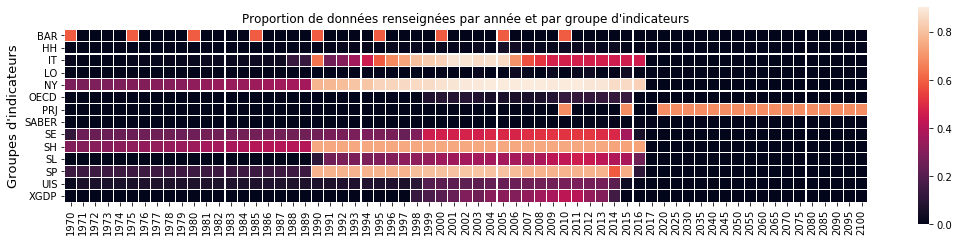

In [11]:
# Heatmap des données présentes par groupe d'indicateurs
fig = plt.figure(figsize=(18,4))

sns.heatmap(group_indic_null, square=True, linewidths=0.1)
plt.title("Proportion de données renseignées par année et par groupe d'indicateurs")
plt.ylabel('Groupes d\'indicateurs', fontsize=13)
plt.show()

L'essentiel des données présentes sont entre l'année 1990 et aujourd'hui.

Les groupes d'indicateurs exploitables sont : BAR, IT, NY, SE, SH, SL, SP, UIS et XGDP

### 2.4 Information sur les groups d'indicateurs

Information sur les groupes d'indicateurs :

BAR : Indicateurs barro-lee, aggrégés sur 5 ans selon 7 niveaux d'éducation

HH : regroupe DHS (Demographic and Health Surveys) et MICS (Multiple Indicator Cluster Surveys)
    
IT : Infrastructure : utilisateurs internet et ordinateurs
        
LO : Learning Outcomes (Evaluation du niveau des éléves en science, lecture..)
    
NY : National Accounts, produits intérieurs et nationaux
    
OECD : OCDE, salaires des enseignants du secteur public
    
PRJ : Projections Wittgenstein (durée de scolarisation, populations..)
    
SABER : System Approach for Better Education
    
SE : Social Education
    
SL : Social Labor
    
SH : Social Health
    
SP : Social Population
    
UIS : Unesco Institute for Statistics
    
XGDP : Dépenses publiques dans l'éducation

### 2.5 Travail sur les données manquantes

On se limite aux indicateurs suivants : BAR, IT, NY, SE, UIS, SP et XGDP

Ceux sont les seuls groupes d'indicateurs qui font référence aux objectifs du projet

In [12]:
indic_group = ["BAR", "IT", "NY", "SE", "UIS", "SP", "XGDP"]

On récupère uniquement les années allant de 1990 à 2015

In [13]:
df = df_data[df_data["Indicator Group"].isin(indic_group)]
# Uniquement les années de 1900 à 2015
df_years = df.loc[:, '1990':'2015']
# Uniquement les variables catégorielles
df_indic = df.loc[:, ["Country Name", "Country Code", "Indicator Name", "Indicator Code", "Indicator Group", "Region"]]

####  Méthode d'interpolation linéaire pour remplacer les valeurs manquantes d'une année à l'autre

In [14]:
# Interpolation sur les années
df_years.interpolate(method="linear", axis=1, limit=5, limit_direction="both", inplace=True)

In [15]:
df = pd.concat([df_indic, df_years], axis=1)

## 3. Selection des indicateurs

#### les 25 premières lignes correspondent aux zones géographiques, le reste correspond à la liste des pays

In [16]:
countries = df["Country Name"].drop_duplicates()
print(countries.head(30))

0                                                Arab World
3665                                    East Asia & Pacific
7330            East Asia & Pacific (excluding high income)
10995                                             Euro area
14660                                 Europe & Central Asia
18325         Europe & Central Asia (excluding high income)
21990                                        European Union
25655                Heavily indebted poor countries (HIPC)
29320                                           High income
32985                             Latin America & Caribbean
36650     Latin America & Caribbean (excluding high income)
40315          Least developed countries: UN classification
43980                                   Low & middle income
47645                                            Low income
51310                                   Lower middle income
54975                            Middle East & North Africa
58640     Middle East & North Africa (ex

#### On séléctionne uniquement les pays

In [17]:
countries = df["Country Name"].drop_duplicates()[25:].values
df = df[df["Country Name"].isin(countries)]

#### On sélectionne uniquement les indicateurs qui sont renseignés pour plus de 100 pays

In [18]:
Indicator_name = (df.groupby("Indicator Name").count()["2015"]>=100)
Indicator_name = Indicator_name[Indicator_name == True]
df_select = df[df["Indicator Name"].isin(Indicator_name.index)]

#### On séléctionne uniquement les pays pour lesquels chacun a plus de 100 indicateurs renseignés

In [19]:
list_countries = df_select.groupby("Country Name").count()["2015"]>100
list_countries = list(list_countries[list_countries==True].index)

In [20]:
df_select_2 = df_select[df_select["Country Name"].isin(list_countries)]

### 3.1 Indicateur sur les ressources informatiques

#### 3.1.1 Indicateurs IT

In [21]:
df_it = df_select_2[df_select_2["Indicator Group"] == "IT"]
for indicator in df_it["Indicator Name"].unique() :
    print(indicator)

Internet users (per 100 people)


#### 3.1.2 Couverture internet

In [22]:
list_regions = df_select_2["Region"].dropna().unique()

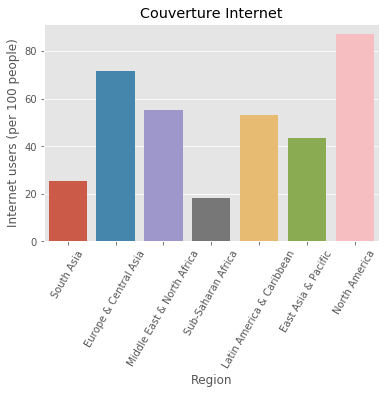

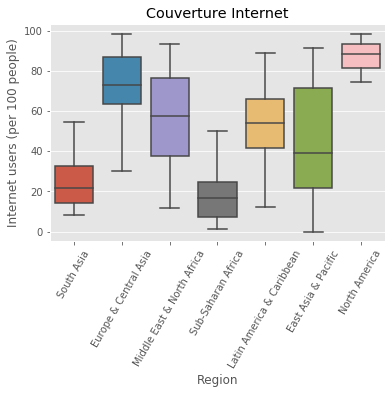

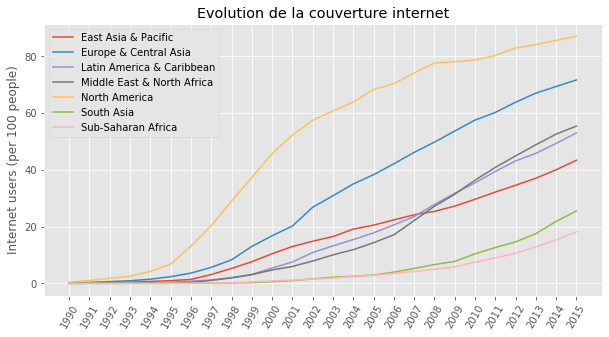

In [89]:
indicator_it = "Internet users (per 100 people)"
df_it = df_select_2[df_select_2["Indicator Name"] == indicator_it]

# Histogramme pour l'année 2014 de la couverture internet pour chaque région
df_it_plot = df_it.groupby('Region').mean()[current_year]
sns.barplot(df_it_plot.index, df_it_plot.values, order=list_regions)
plt.xticks(rotation=60)
plt.title("Couverture Internet")
plt.ylabel(indicator_it)
plt.style.use('ggplot')
plt.show()

# Boite à moustaches, couverture internet de chaque pays
sns.boxplot(data=df_it, y=current_year, x='Region', showfliers=False)
plt.ylabel(indicator_it)
plt.xticks(rotation=60)
plt.title("Couverture Internet")
plt.style.use('ggplot')
plt.show()

# Série temporelle
fig = plt.figure(1, figsize=(10,5))
series = df_it.groupby("Region").mean()
for region in series.index :
    plt.plot(series.loc[region, :], label=region)
plt.xticks(rotation=60)
plt.title("Evolution de la couverture internet")
plt.ylabel(indicator_it)
plt.legend()
plt.show()

- Il y a de fortes inégalités entre régions géographiques mais également au sein d'une même région
- Il y a une forte croissance de la couverture internet qui démarre dans les années 90, certaines régions connaissent un retard certain qui n'est pas encore rattrapé

### 3.2 Richesse des pays

#### 3.2.1 Indicateurs NY

In [24]:
df_ny = df_select_2[df_select_2["Indicator Group"] == "NY"]
for indicator in df_ny["Indicator Name"].unique() :
    print(indicator)

GDP at market prices (constant 2005 US$)
GDP at market prices (current US$)
GDP per capita (constant 2005 US$)
GDP per capita (current US$)
GDP per capita, PPP (constant 2011 international $)
GDP per capita, PPP (current international $)
GDP, PPP (constant 2011 international $)
GDP, PPP (current international $)
GNI (current US$)
GNI per capita, Atlas method (current US$)
GNI per capita, PPP (current international $)
GNI, PPP (current international $)


#### 3.2.2 PIB par habitant ($)

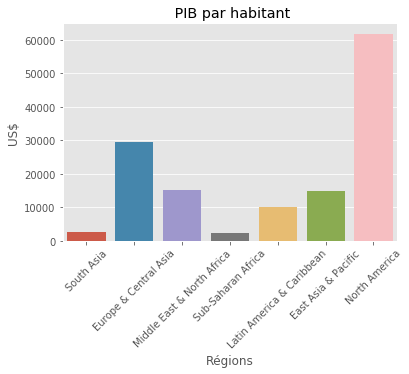

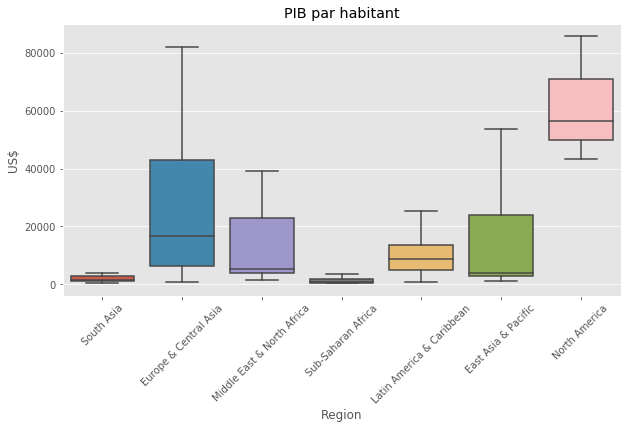

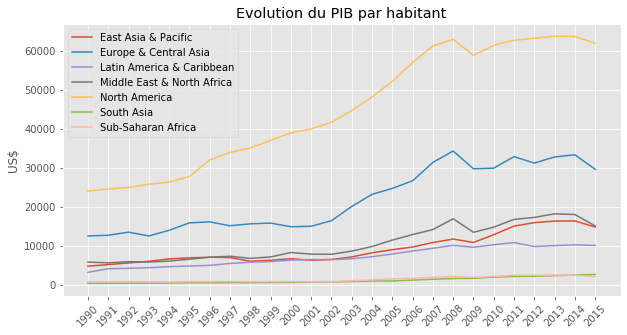

In [25]:
# ------------ PIB par habitant -----------
# Bar plot pour chaque région
indicator_pib = 'GDP per capita (current US$)'
df_PIB = df_select_2[df_select_2["Indicator Name"] == indicator_pib]
df_PIB_plot = df_PIB.groupby("Region").mean()[current_year]
sns.barplot(df_PIB_plot.index, df_PIB_plot.values, order=list_regions)
plt.title(" PIB par habitant")
plt.xticks(rotation=45)
plt.ylabel("US$")
plt.xlabel("Régions")
plt.style.use('ggplot')
plt.show()

# Boite à moustaches
fig = plt.figure(1, figsize=(10,5))
sns.boxplot(data=df_PIB, y=current_year, x="Region", showfliers=False)
plt.title("PIB par habitant")
plt.ylabel("US$")
plt.xticks(rotation=45)
plt.show()

# Série temporelle
fig = plt.figure(1, figsize=(10,5))
series = df_PIB.groupby("Region").mean()
for region in series.index :
    plt.plot(series.loc[region, :], label=region)
plt.xticks(rotation=45)
plt.title("Evolution du PIB par habitant")
plt.ylabel("US$")
plt.legend()
plt.show()

- Les inégalités de PIB sont très marqués d'une région à l'autre
- La crise financière de 2008 fait chuter le PIB qui connait ensuite une croissance bien moindre voir un début de baisse à partir de 2014

### 3.3 Indicateurs relatifs à l'éducation

On s'intéresse aux groupes d'indicateurs suivantes : BAR, SE et UIS

Des indicateurs de chaque groupe sont séléctionnés en fonction de leur lien avec notre application

#### 3.3.1 Indicateurs Barro-Lee

In [26]:
for ind in df_select_2[df_select_2["Indicator Group"] == "BAR"]["Indicator Name"].unique() :
    if "Percentage" in ind :
        print(ind)

Barro-Lee: Percentage of female population age 15+ with no education
Barro-Lee: Percentage of female population age 15+ with primary schooling. Completed Primary
Barro-Lee: Percentage of female population age 15+ with primary schooling. Total (Incomplete and Completed Primary)
Barro-Lee: Percentage of female population age 15+ with secondary schooling. Completed Secondary
Barro-Lee: Percentage of female population age 15+ with secondary schooling. Total (Incomplete and Completed Secondary)
Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Completed Tertiary
Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Total (Incomplete and Completed Tertiary)
Barro-Lee: Percentage of female population age 15-19 with no education
Barro-Lee: Percentage of female population age 15-19 with primary schooling. Completed Primary
Barro-Lee: Percentage of female population age 15-19 with primary schooling. Total (Incomplete and Completed Primary)
Barro-Le

In [27]:
indicators_education = ["Barro-Lee: Percentage of population age 25-29 with secondary schooling. Total (Incomplete and Completed Secondary)",
                 "Barro-Lee: Percentage of population age 20-24 with secondary schooling. Total (Incomplete and Completed Secondary)"
                 ]

#### 3.3.2 Indicateurs Social Education

In [28]:
for ind in df_select_2[df_select_2["Indicator Group"] == "SE"]["Indicator Name"].unique() :
    if 'both sexes (%)' in ind :
        print(ind)

Adjusted net enrolment rate, primary, both sexes (%)
Adult literacy rate, population 15+ years, both sexes (%)
Cumulative drop-out rate to the last grade of primary education, both sexes (%)
Effective transition rate from primary to lower secondary general education, both sexes (%)
Gross enrolment ratio, lower secondary, both sexes (%)
Gross enrolment ratio, pre-primary, both sexes (%)
Gross enrolment ratio, primary to tertiary, both sexes (%)
Gross enrolment ratio, primary, both sexes (%)
Gross enrolment ratio, secondary, both sexes (%)
Gross enrolment ratio, tertiary, both sexes (%)
Gross enrolment ratio, upper secondary, both sexes (%)
Gross graduation ratio from first degree programmes (ISCED 6 and 7) in tertiary education, both sexes (%)
Gross graduation ratio from primary education, both sexes (%)
Gross intake ratio to Grade 1 of primary education, both sexes (%)
Lower secondary completion rate, both sexes (%)
Net enrolment rate, pre-primary, both sexes (%)
Net enrolment rate, pr

In [29]:
indicators_education.extend(["Lower secondary completion rate, both sexes (%)",
                "Net enrolment rate, secondary, both sexes (%)",
                "Primary completion rate, both sexes (%)",
                "Youth literacy rate, population 15-24 years, both sexes (%)"    
               ])

#### 3.3.3 Indicateurs Unesco Institut for Statistics

In [30]:
for ind in df_select_2[df_select_2["Indicator Group"] == "UIS"]["Indicator Name"].unique() :
    if "(%)" in ind :
        if not "male" in ind :
            print(ind)

Adjusted net enrolment rate, lower secondary, both sexes (%)
Adjusted net enrolment rate, upper secondary, both sexes (%)
Adjusted net intake rate to Grade 1 of primary education, both sexes (%)
All staff compensation as % of total expenditure in primary public institutions (%)
All staff compensation as % of total expenditure in public institutions (%)
All staff compensation as % of total expenditure in secondary public institutions (%)
All staff compensation as % of total expenditure in tertiary public institutions (%)
All staff compensation as % of total expenditure in upper secondary public institutions (%)
Capital expenditure as % of total expenditure in primary public institutions (%)
Capital expenditure as % of total expenditure in public institutions (%)
Capital expenditure as % of total expenditure in secondary public institutions (%)
Capital expenditure as % of total expenditure in tertiary public institutions (%)
Cumulative drop-out rate to the last grade of lower secondary g

In [31]:
indicators_education.append("Net enrolment rate, upper secondary, both sexes (%)")

#### 3.3.4 Affichage graphique

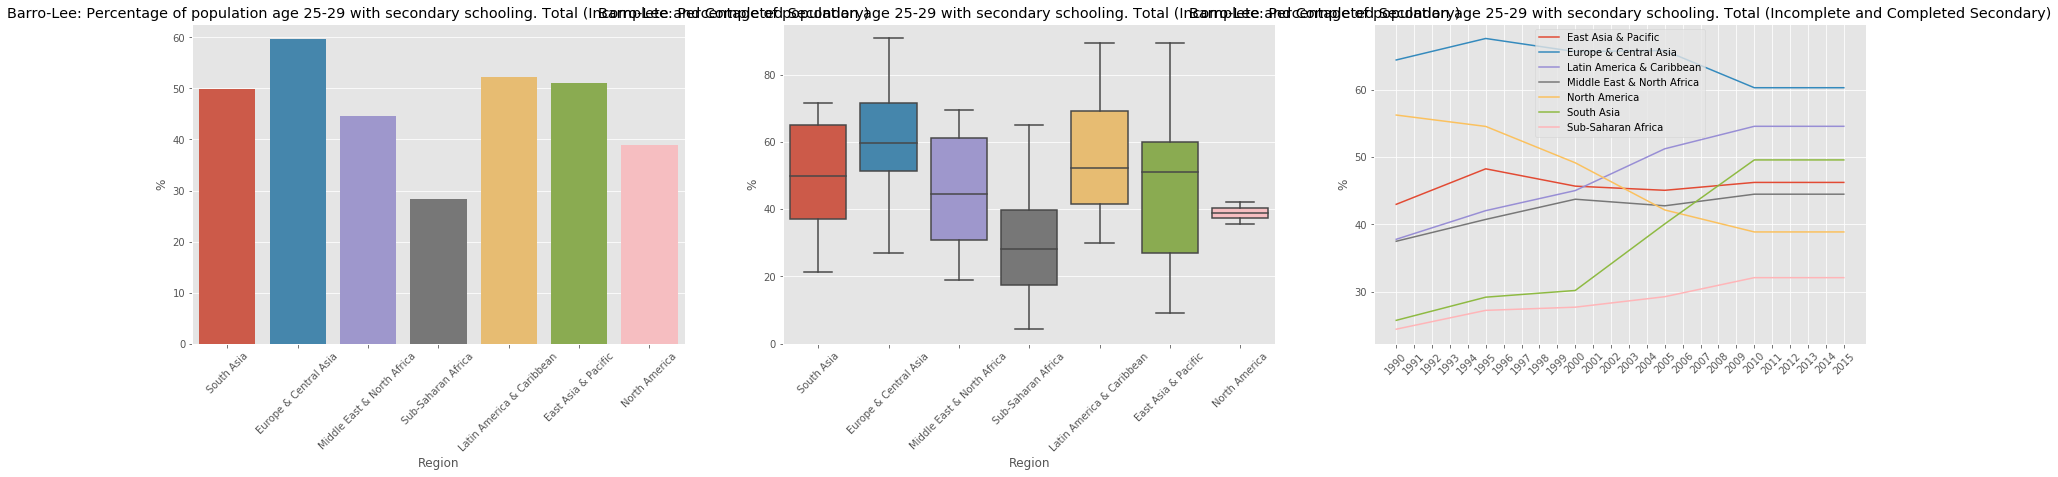

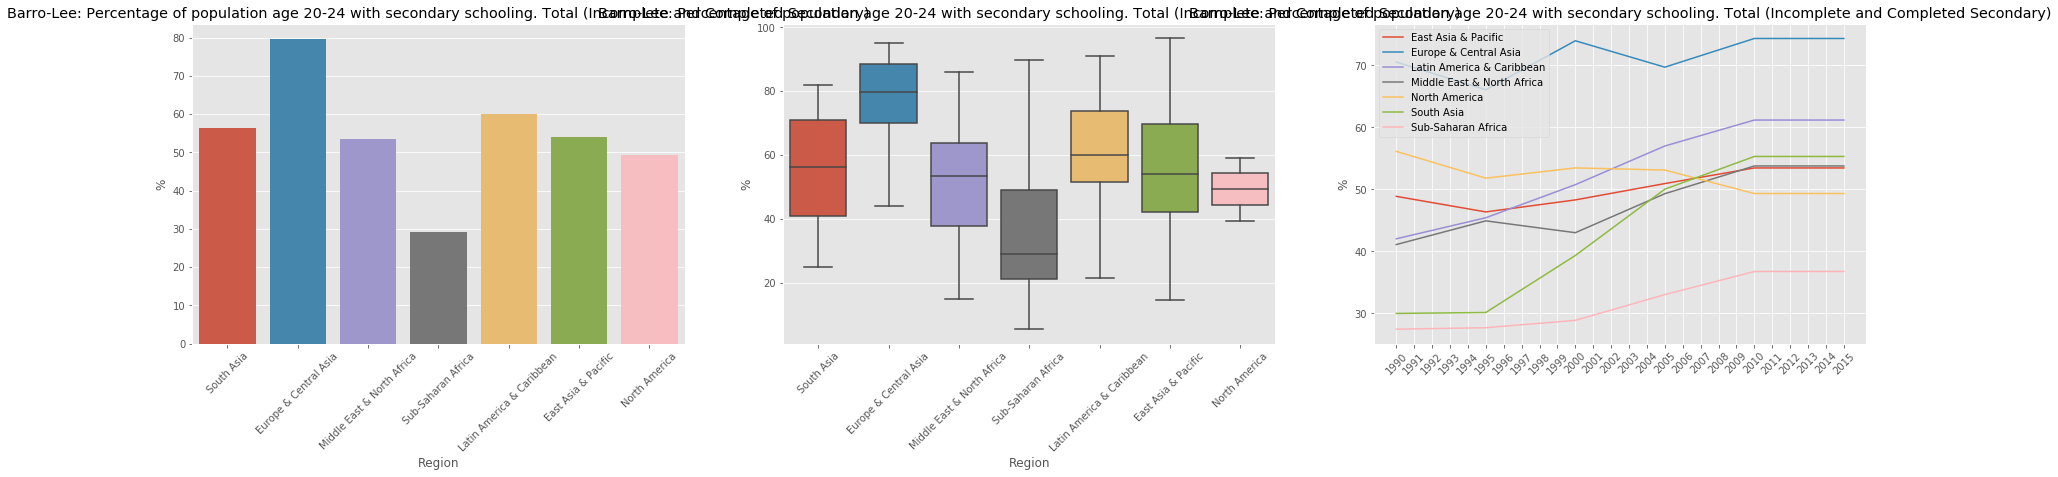

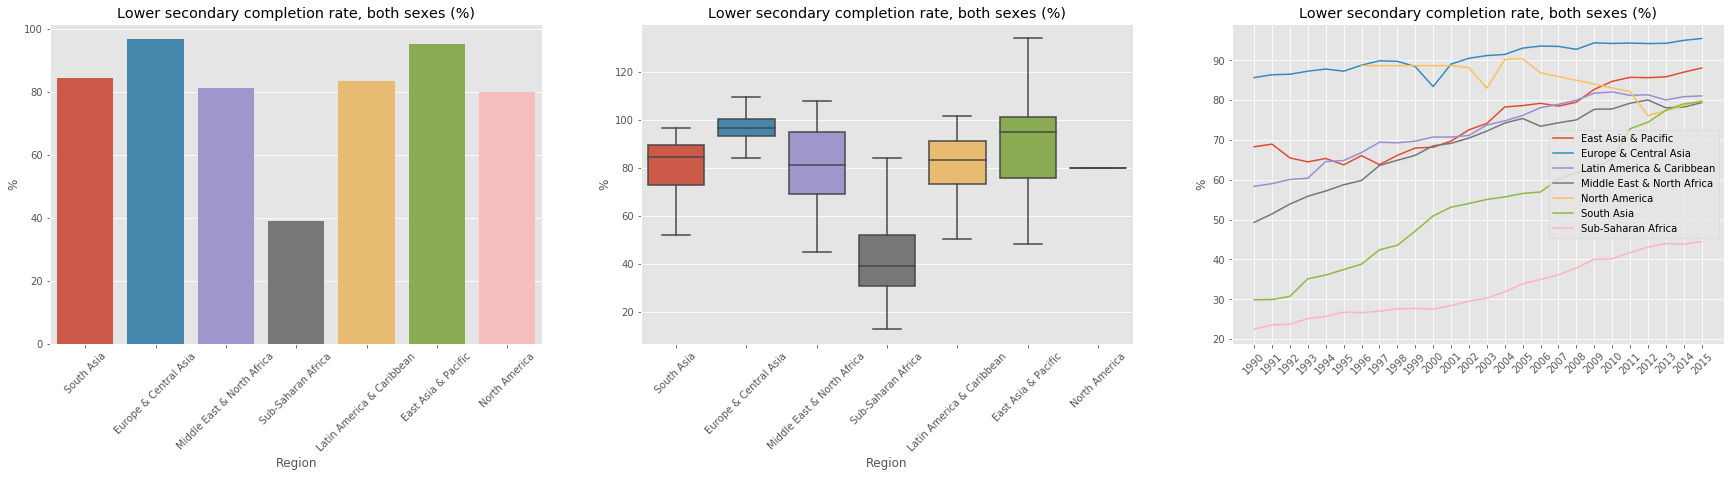

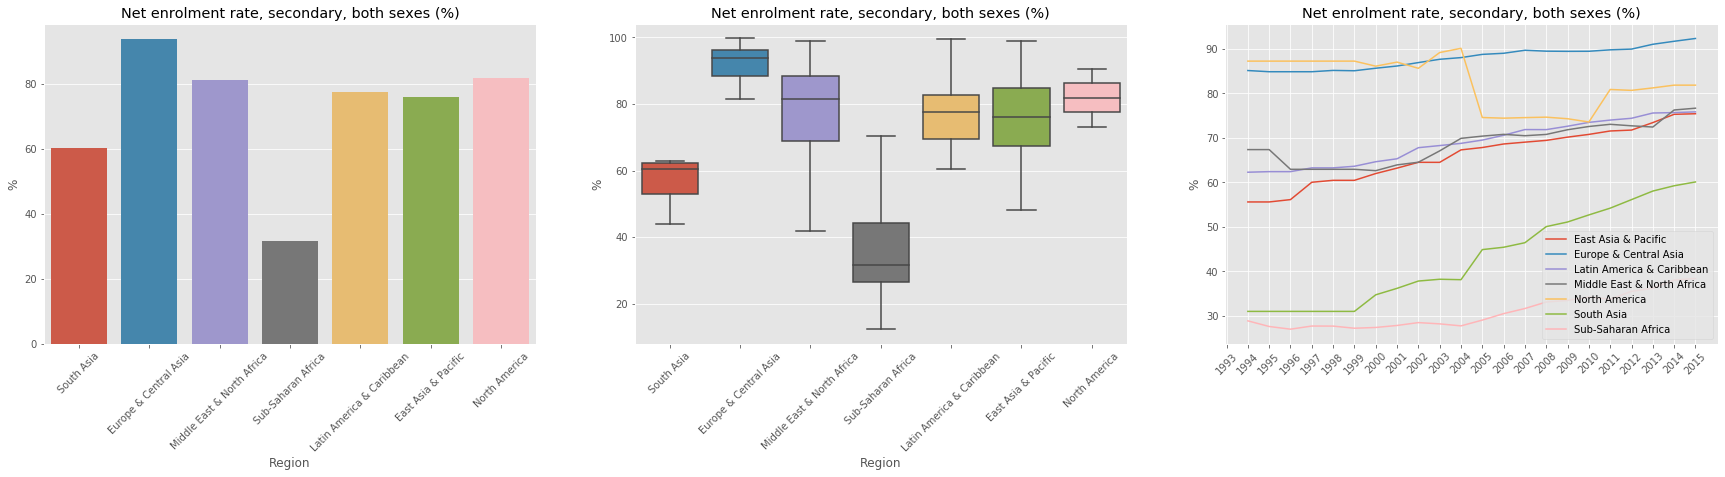

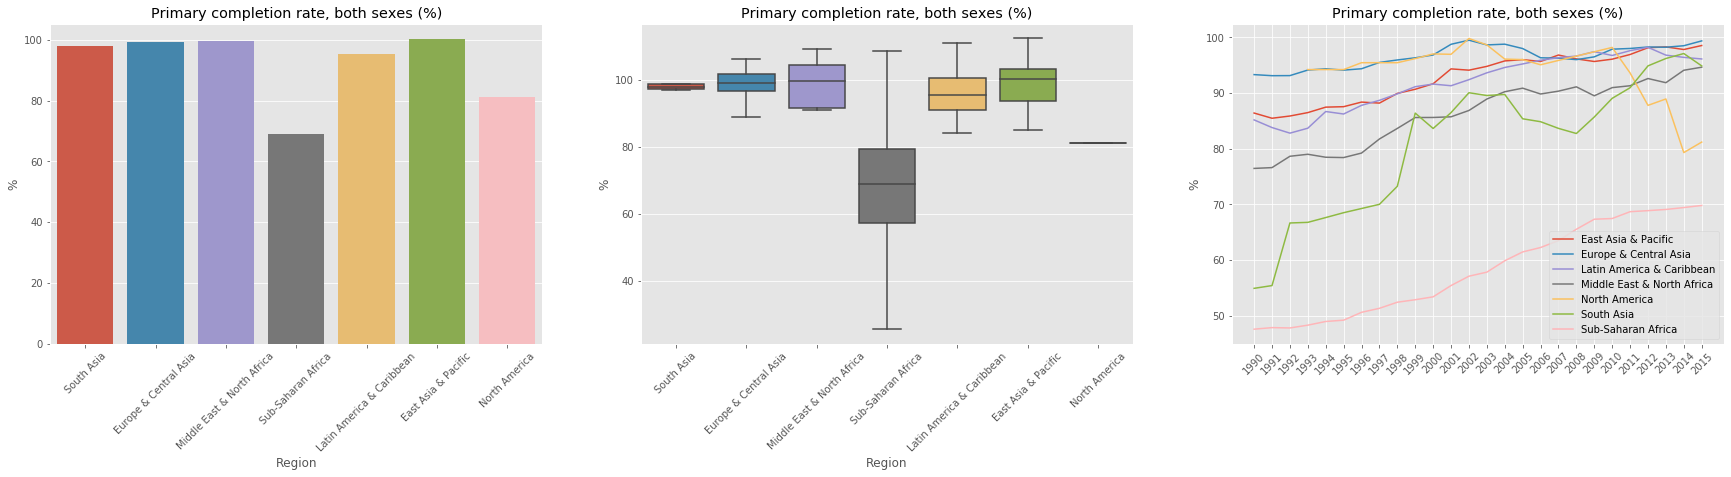

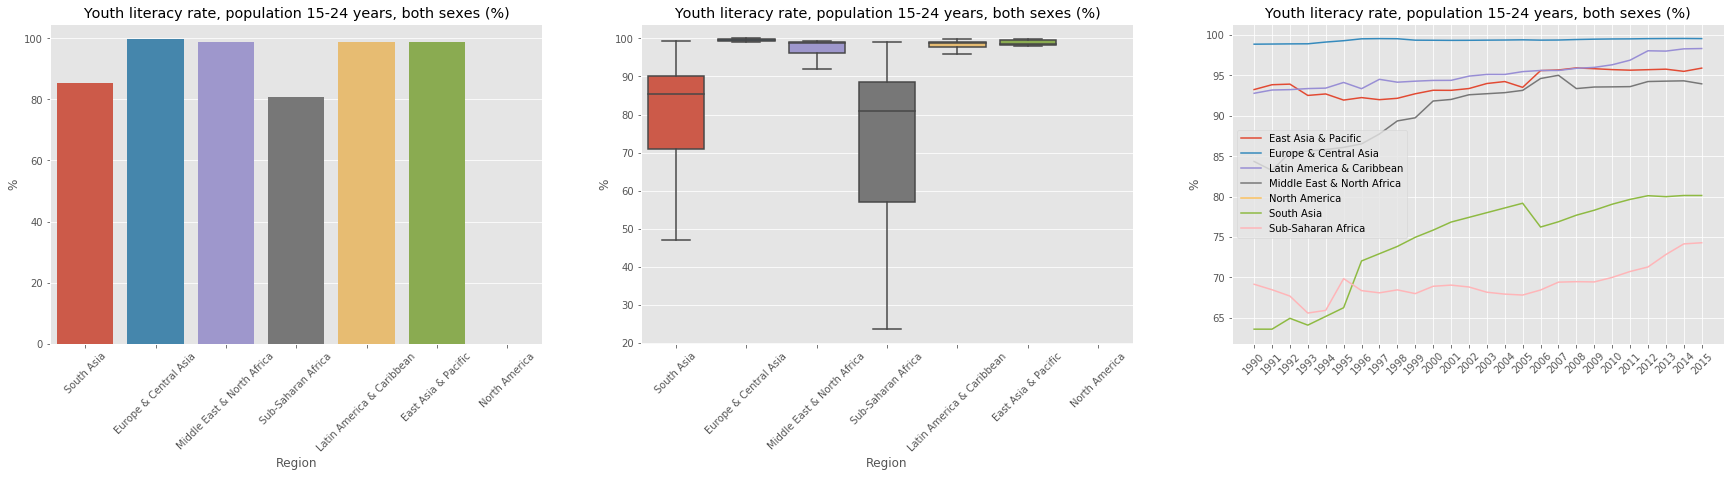

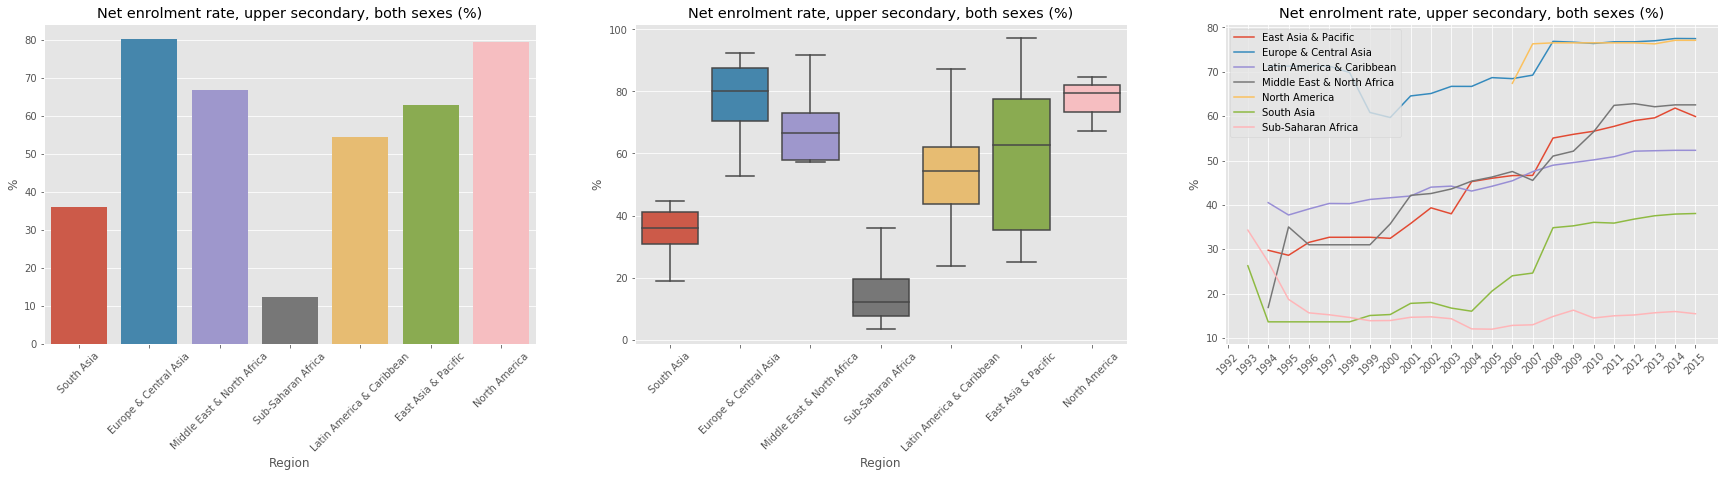

In [32]:
# Bar plot pour chaque région
for indicator in indicators_education :
    
    fig = plt.figure(1, figsize=(30,20))
    df_ind = df_select_2[df_select_2["Indicator Name"] == indicator]
    df_ind_plot = df_ind.groupby("Region").median()["2015"]
    plt.subplot(331)
    sns.barplot(df_ind_plot.index, df_ind_plot.values, order=list_regions)
    plt.title(indicator)
    plt.xticks(rotation=45)
    plt.style.use('ggplot')
    plt.ylabel("%")

    # Boite à moustaches
    plt.subplot(332)
    plt.title(indicator)
    sns.boxplot(data=df_ind, y="2015", x="Region", showfliers=False)
    plt.xticks(rotation=45)
    plt.ylabel("%")
    
    # Série temporelle
    plt.subplot(333)
    series = df_ind.groupby("Region").mean()
    plt.title(indicator)
    for region in series.index :
        plt.plot(series.loc[region, :], label=region)
    plt.legend()
    plt.ylabel("%")
    plt.xticks(rotation=45)
    plt.show()

- Les inégalités sont plus fortes pour le taux d'education dans le secondaire que dans le primaire
- Globalement, tous les indicateurs sont en légère hausse
- L'Amérique du nord est manquante pour certains indicateurs
- Les taux d’inscription dans dans le secondaire supérieur sont très inégales d’une région à l’autre
- Le taux d’inscription dans le secondaire supérieur connaît une période de stagnation à partir de 2008, période marqué par la crise financière
- L'Afrique subsaharienne et l'Asie du sud connaissent encore de forts taux d'analphébétisme


### 3.3 Indicateurs sur les dépenses publiques

#### 3.3.1 Indicateurs XGDP

In [33]:
df_ny = df_select_2[df_select_2["Indicator Group"] == "XGDP"]
for indicator in df_ny["Indicator Name"].unique() :
    print(indicator)

Government expenditure in secondary institutions education as % of GDP (%)
Government expenditure in tertiary institutions as % of GDP (%)


In [34]:
indicators_expenses = list(df_ny["Indicator Name"].unique())

#### 3.3.2 Dépenses publiques % du PIB

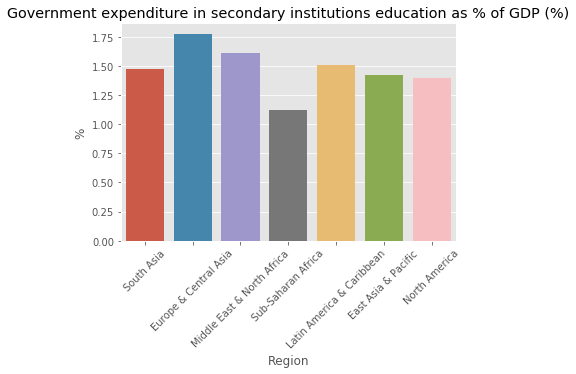

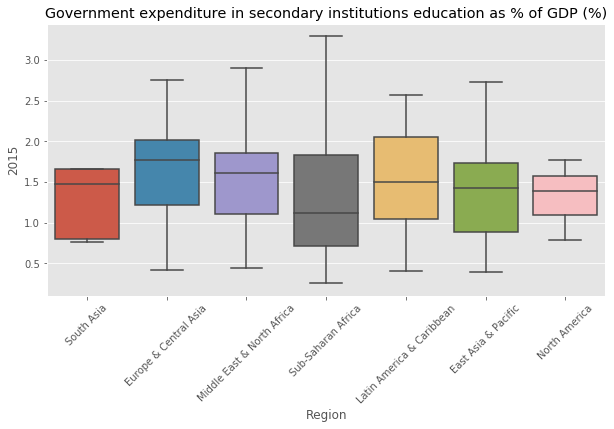

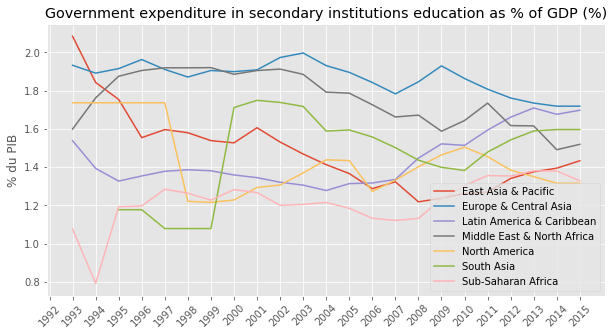

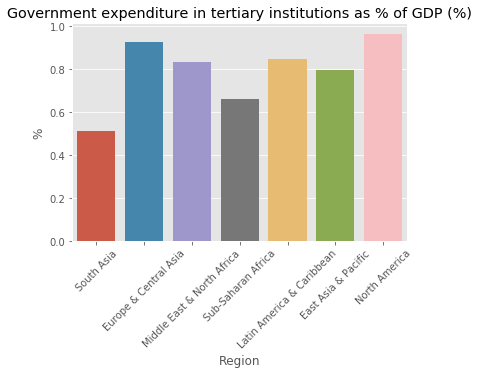

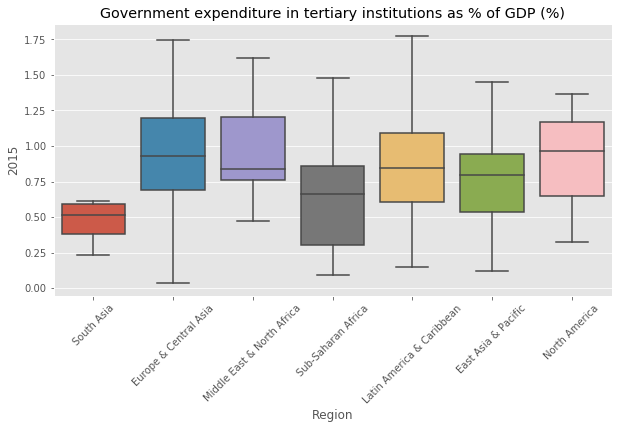

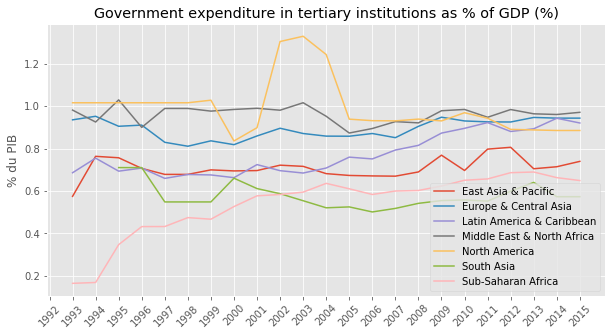

In [83]:
# ------------ Dépenses publiques, % du PIB -----------
# Bar plot pour chaque région
for indicator in df_ny["Indicator Name"].unique() :
    
    df_exp = df_select_2[df_select_2["Indicator Name"] == indicator]
    df_exp_plot = df_exp.groupby("Region").median()["2015"]
    sns.barplot(df_exp_plot.index, df_exp_plot.values, order=list_regions)
    plt.title(indicator)
    plt.xticks(rotation=45)
    plt.style.use('ggplot')
    plt.ylabel("%")
    plt.show()

    # Boite à moustaches
    fig = plt.figure(1, figsize=(10,5))
    sns.boxplot(data=df_exp, y="2015", x="Region", showfliers=False)
    plt.xticks(rotation=45)
    plt.title(indicator)
    plt.show()
    
    # Série temporelle
    fig = plt.figure(1, figsize=(10,5))
    series = df_exp.groupby("Region").mean()
    for region in series.index :
        plt.plot(series.loc[region, :], label=region)
    plt.legend()
    plt.title(indicator)
    plt.xticks(rotation=45)
    plt.ylabel("% du PIB")
    plt.legend()
    plt.show()

- Les dépenses publiques sont assez homogènes entre régions

- Les dépenses publiques pour l'éducation secondaire sont en hausse pour les pays dévéloppés et en baisse pour les pays émergents

- Pour les dépenses dans le tertiaire, la tendance est relativement stable à part pour l'Afrique subsaharienne qui connait une croissance importante



### 3.4 Indicateurs sur la population

#### 3.4.1 Indicateurs SP

In [36]:
df_pop = df_select_2[df_select_2["Indicator Group"] == "SP"]
for indicator in df_pop["Indicator Name"].unique() :
    print(indicator)

Government expenditure in secondary institutions education as % of GDP (%)
Government expenditure in tertiary institutions as % of GDP (%)


In [37]:
indicator_population = ["Population, total"]

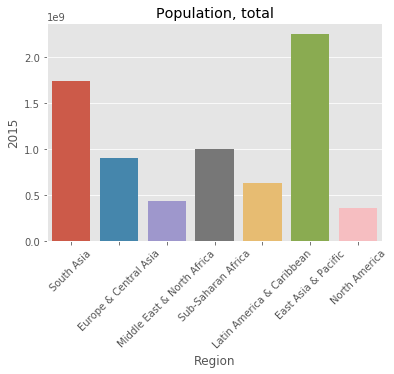

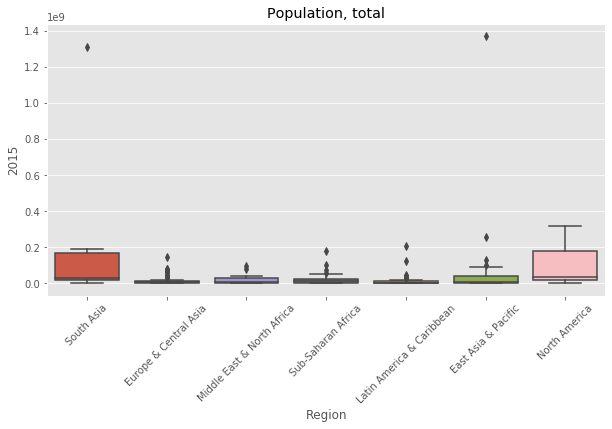

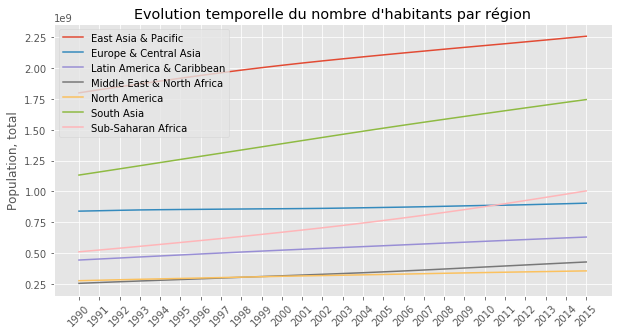

In [77]:
# ------------ Population, Nombre total de femmes et d'hommes -----------
# Bar plot pour chaque région
for indicator in indicator_population :
    
    df_pop = df_select_2[df_select_2["Indicator Name"] == indicator]
    df_pop_plot = df_pop.groupby("Region").sum()["2015"]
    sns.barplot(df_pop_plot.index, df_pop_plot.values, order=list_regions)
    plt.title(indicator)
    plt.xticks(rotation=45)
    plt.ylabel("2015")
    plt.style.use('ggplot')
    plt.show()

    # Boite à moustaches
    fig = plt.figure(1, figsize=(10,5))
    sns.boxplot(data=df_pop, y="2015", x="Region", showfliers=True)
    plt.xticks(rotation=45)
    plt.title(indicator)
    plt.show()
    
    # Série temporelle
    fig = plt.figure(1, figsize=(10,5))
    series = df_pop.groupby("Region").sum()
    for region in series.index :
        plt.plot(series.loc[region, :], label=region)
    plt.legend()
    plt.xticks(rotation=45)
    plt.ylabel(indicator)
    plt.title("Evolution temporelle du nombre d'habitants par région")
    plt.legend()
    plt.show()

- La démographie par pays indique le nombre d'utilisateurs potentiels pour notre application

- Les 2 outliers présents sur le graphique des boxplots sont la Chine et l'Inde

- La population est très nombreuse en Asie du Sud et en Asie-Pacifique


## 4. Séléction des pays prioritaires

In [39]:
# Sont regroupés tous les indicateurs
all_indicators = indicators_education + [indicator_pib] + indicators_expenses + [indicator_it] + indicator_population
df_select_3 = df_select_2[df_select_2["Indicator Name"].isin(all_indicators)]

In [40]:
# On effectue la moyenne sur les 6 dernières années
df_select_3["mean_2010_2015"] = df_select_3.loc[:, "2010":"2015"].mean(axis=1)

C:\Users\nadin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Modèle de scoring :

 - Les valeurs manquantes sont remplacés par la médiane

 - Une moyenne est effectué pour obtenir qu'une seule valeur par type d'indicateurs

 - Les valeurs sont normalisés

 - Un score est calculé par moyenne arithmétique des 4 types d'indicateurs

In [41]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
imputer = Imputer(strategy="median")
encoder = StandardScaler()


def score(data, year) :
    
    df_final =  data.pivot_table(index='Country Name', columns="Indicator Name")[year]
    df_final = pd.DataFrame(imputer.fit_transform(df_final), columns=df_final.columns, index=df_final.index)
    
    education = df_final[indicators_education].mean(axis=1)
    expenses = df_final[indicators_expenses].mean(axis=1)
    pib = df_final[[indicator_pib]].mean(axis=1)
    it = df_final[[indicator_it]].mean(axis=1)
    population = df_final[indicator_population].mean(axis=1)

    df_score = pd.DataFrame({'pib': pib, 'education' : education, 'expenses': expenses, 'it' : it, 'population': population})
    df_score_encoded = pd.DataFrame(encoder.fit_transform(df_score), index=df_score.index, columns=df_score.columns)
    df_score_encoded["score"] = df_score_encoded.mean(axis=1)
    
    return df_score_encoded

C:\Users\nadin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
df_score = score(df_select_3, "mean_2010_2015")

### 4.1 Analyse des résultats

####  Les résultats sont moyennés par Région

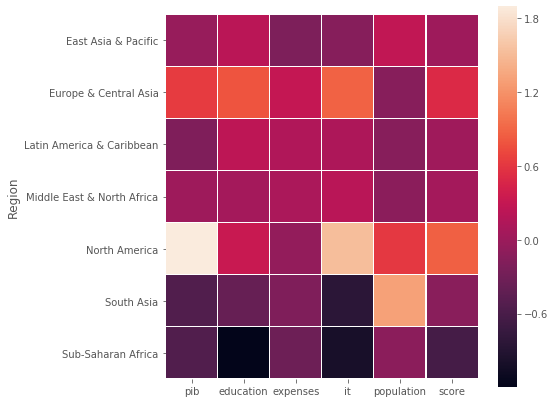

In [43]:
regions = df_select_3[["Country Name", "Region"]].drop_duplicates().set_index("Country Name")
df_score["Region"] = regions
df_score_per_region = df_score.groupby("Region").mean()

fig = plt.figure(1, figsize=(7, 7))
sns.heatmap(df_score_per_region, square=True, linewidths=0.1)
plt.show()

L'Europe, l'Asie centrale et l'Amérique du nord connaissent les scores les plus élevés

#### Visualisation des critères par région

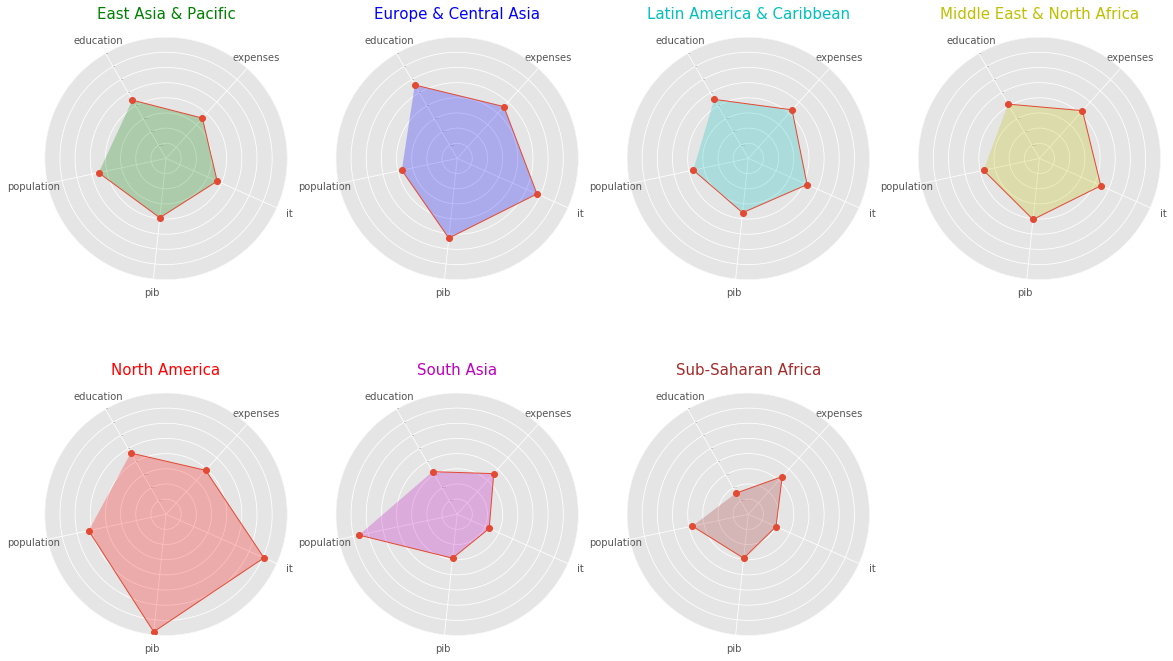

In [86]:
from math import pi

df_plot = df_score_per_region[['education','expenses','it','pib', 'population']]


# number of variable
categories=list(df_plot.columns)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]

 
fig = plt.figure(1, figsize=(20,12))
    
colors = ['g', 'blue', 'c', 'y', 'red', 'm','brown']

for i, region in enumerate(df_plot.index) : 
    
    ax = fig.add_subplot(2,4,i+1, polar=True)

    ax.set_theta_offset(2*pi/3)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)

    # Draw one axe per variable + add labels labels yet
    #plt.xticks(angles, categories, size=8)
    plt.yticks(color="grey", size=2)
    values=df_plot.iloc[i].values
    ax.plot(angles, values, 'o-', linewidth=1)
    ax.fill(angles, values, colors[i], alpha=0.25)
    ax.set_xticks(angles)
    ax.set_xticklabels(categories)
    ax.set_title(region, size=15, color=colors[i])
    ax.grid(True)
    plt.ylim(-2,2)

plt.show()


- Les pays qui ont le plus haut potentiel sont ceux qui la plus grande aire dans le graphique

- L'Afrique subsaharienne et l'Asie du Sud semblent être les régions ayant le moins de potentiel client


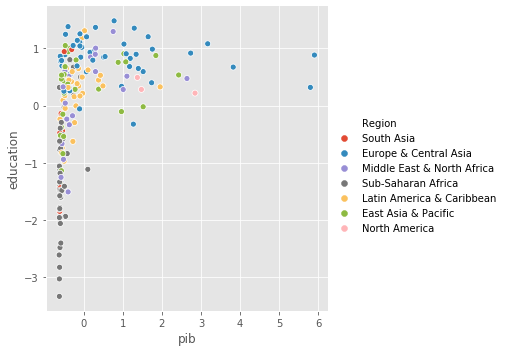

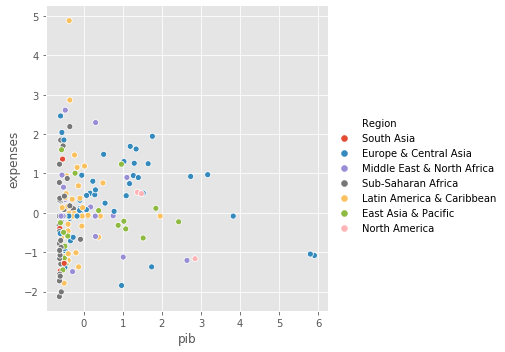

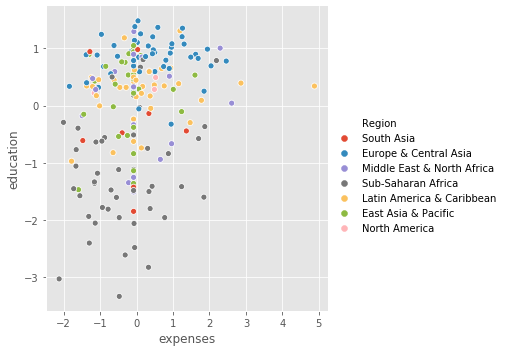

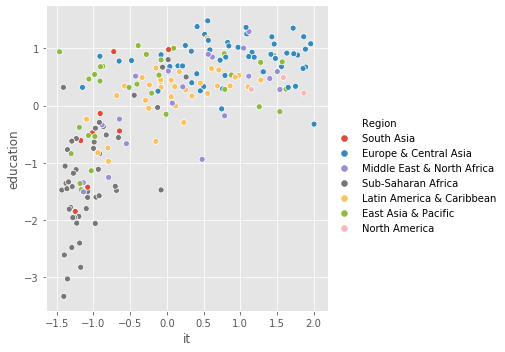

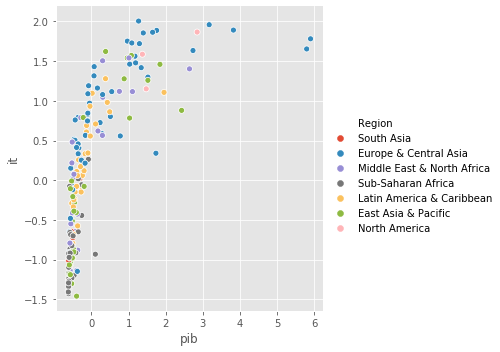

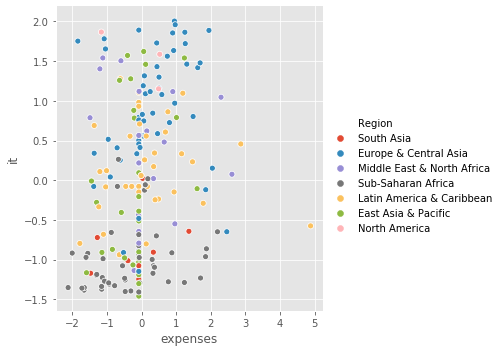

In [45]:
sns.relplot(x='pib', y='education', hue='Region', data=df_score)
sns.relplot(x='pib', y='expenses', hue='Region', data=df_score)
sns.relplot(x='expenses', y='education', hue='Region', data=df_score)
sns.relplot(x='it', y='education', hue='Region', data=df_score)
sns.relplot(x='pib', y='it', hue='Region', data=df_score)
sns.relplot(x='expenses', y='it', hue='Region', data=df_score)

plt.show()

- Les régions où le potentiel de clients est le plus élevé sont l'Europe et l'Asie centrale

- A contrario l'Afrique subsaharienne semble la moins promettante

### 4.2 Liste des 50 pays prioritaires en 2015

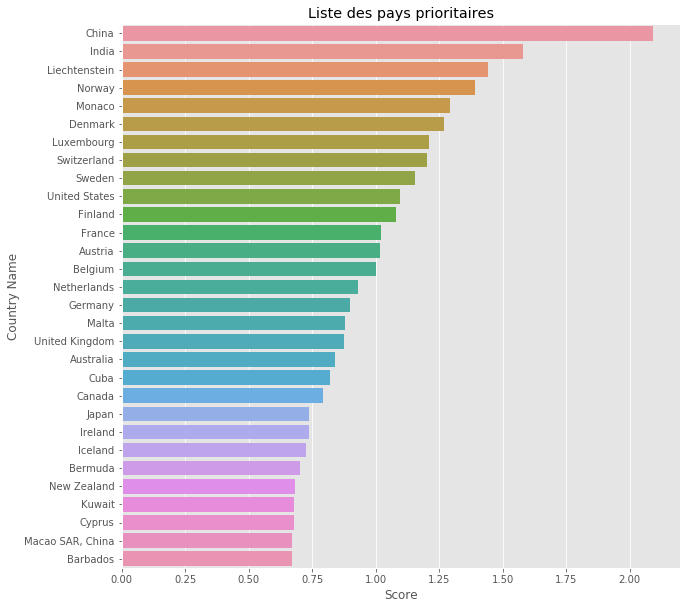

In [46]:
fig = plt.figure(1, figsize=(10, 10))
# Liste des 30 pays ayant le score le plus élevé (par ordre décroissant)
list_priority_countries = df_score["score"].sort_values(ascending=False)[0:30]
sns.barplot(list_priority_countries.values, list_priority_countries.index, orient='h')
plt.xlabel("Score")
plt.title("Liste des pays prioritaires")
plt.show()

#### Etude de quelques pays en haut du classement

In [84]:
df_score.loc[["Monaco","Liechtenstein", "China"]]

,pib,education,expenses,it,population,score,Region,score_2020,evolution
Country Name,,,,,,,,,
Monaco,5.797409,0.317099,-1.046485,1.653648,-0.260933,1.292148,Europe & Central Asia,1.271197,-0.020950
Liechtenstein,5.901485,0.882266,-1.083039,1.781472,-0.260941,1.444249,Europe & Central Asia,2.007255,0.563006
China,-0.373744,1.001777,-0.082774,0.093843,9.822034,2.092227,East Asia & Pacific,2.072233,-0.019994


- Moncao et Liechtenstein arrivent en haut du classement car leur PIB est très élevé

- La Chine quant à elle arrive en tête du podium par son importante démographie

### 4.3 Evolution du potentiel des pays : projection en 2020

Une régréssion linéaire sur les années 2010 à 2015 est calculé pour chaque pays, permet d'avoir une projection pour l'année 2020

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

df_potentiel = np.array([score(df_select_3, year)["score"] for year in ["2010", "2011", "2012", "2013", "2014", "2015"]]).T
x = np.array([2010, 2011, 2012, 2013, 2014, 2015]).reshape(-1,1)
score_2020 = []
for y in df_potentiel :
    lin_reg.fit(x, y.reshape(-1, 1))
    score_2020.append(lin_reg.predict(np.array([2020]).reshape(-1,1))[0][0])
df_score["score_2020"] = score_2020

In [51]:
# Calcul de l'évolution du score entre 2020 et 2015
df_score["evolution"] = df_score["score_2020"] - df_score["score"]

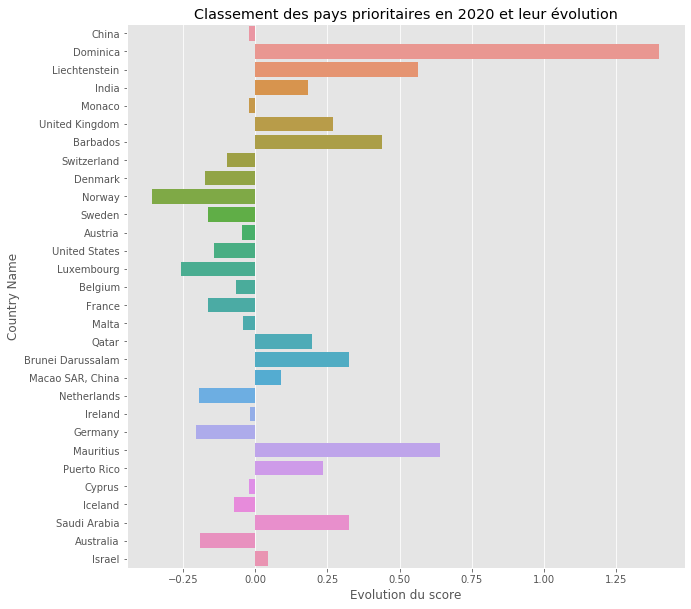

In [52]:
fig = plt.figure(1, figsize=(10, 10))
# Liste des 30 pays les mieux notés
list_futur_priority_countries = df_score["score_2020"].sort_values(ascending=False)[0:30]

# Evolution du score des 30 pays les mieux notés en 2020
new_pays = df_score.loc[list_futur_priority_countries.index, :]["evolution"]
sns.barplot(new_pays.values, new_pays.index, orient='h')
plt.xlabel("Evolution du score")
plt.title("Classement des pays prioritaires en 2020 et leur évolution")
plt.show()

#### 5 pays qui montent et 5 pays qui descendent dans le classement

In [53]:
# Evolution du score pour les 30 pays les mieux notés en 2020

# Pays qui montent dans le classement
positif = df_score[df_score["evolution"]>=0].loc[list_futur_priority_countries.index, :]["evolution"].sort_values(ascending=False)
# Pays qui descendent dans le classement
negatif = df_score[df_score["evolution"]<0].loc[list_futur_priority_countries.index, :]["evolution"].sort_values(ascending=False)

C:\Users\nadin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [54]:
print("Les 5 pays qui montent le plus dans le classement sont : \n \
    - {} \n \
    - {} \n \
    - {} \n \
    - {} \n \
    - {} \n ".format(positif.index[0], positif.index[1], positif.index[2], positif.index[3], positif.index[4] )
     )

print("Ceux à la baisse :\n \
    - {} \n \
    - {} \n \
    - {} \n \
    - {} \n \
    - {} \n ".format(negatif.index[0], negatif.index[1], negatif.index[2], negatif.index[3], negatif.index[4])
     )

Les 5 pays qui montent le plus dans le classement sont : 
     - Dominica 
     - Mauritius 
     - Liechtenstein 
     - Barbados 
     - Saudi Arabia 
 
Ceux à la baisse :
     - Ireland 
     - China 
     - Monaco 
     - Cyprus 
     - Malta 
 
